<a href="https://colab.research.google.com/github/marpom03/hand_gesture_game/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalacja bibliotek

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
!pip install --upgrade pip
!pip install mediapipe
!pip install mediapipe-model-maker
!pip install tensorflow

# Przygotowanie danych

In [ ]:
%matplotlib inline

from google.colab import files
import os
import tensorflow as tf
assert tf.__version__.startswith('2')
from mediapipe_model_maker import gesture_recognizer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


dataset_path = "/content/drive/MyDrive/hand_gesture_recognition/final_dataset"
train_dir = "/content/drive/MyDrive/hand_gesture_recognition/final_dataset/train"
validation_dir = "/content/drive/MyDrive/hand_gesture_recognition/final_dataset/validation"
test_dir = "/content/drive/MyDrive/hand_gesture_recognition/final_dataset/test"

train_data = gesture_recognizer.Dataset.from_folder(
    dirname=train_dir,
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)

validation_data = gesture_recognizer.Dataset.from_folder(
    dirname=validation_dir,
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)

test_data = gesture_recognizer.Dataset.from_folder(
    dirname=test_dir,
    hparams=gesture_recognizer.HandDataPreprocessingParams(True, 0.1)
)

labels = set()  # Używamy zestawu, aby uniknąć duplikatów

# Przechodzimy przez train, validation, i test
for subset in ['train', 'validation', 'test']:
    subset_dir = os.path.join(dataset_path, subset)
    if os.path.exists(subset_dir):  # Upewniamy się, że folder istnieje
        for i in os.listdir(subset_dir):
            if os.path.isdir(os.path.join(subset_dir, i)):
                labels.add(i)  # Dodajemy etykiety do zbioru

# Konwersja zbioru na listę
labels = list(labels)

print("Zidentyfikowane klasy:", labels)

# Trenowanie modelu

In [ ]:
import shutil

# Usuwanie katalogu z zapisanym modelem
model_dir = "exported_model"
if os.path.exists(model_dir):
    shutil.rmtree(model_dir)

hparams = gesture_recognizer.HParams(batch_size = 16, epochs = 40, shuffle=True, export_dir="exported_model")
model_options = gesture_recognizer.ModelOptions(dropout_rate=0.4)
options = gesture_recognizer.GestureRecognizerOptions(hparams=hparams)
model = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)

#Eksportowanie modelu

In [ ]:
model.export_model()

# Ewaluacja modelu

In [ ]:
# Ocena modelu na zbiorze testowym
loss, acc = model.evaluate(test_data, batch_size=1)
print(f"Test loss:{loss}, Test accuracy:{acc}")

# Ocena modelu na zbiorze treningowym
train_loss, train_acc = model.evaluate(train_data, batch_size=1)
print(f"Train loss: {train_loss}, Train accuracy: {train_acc}")

# Ocena modelu na zbiorze walidacyjnym
val_loss, val_acc = model.evaluate(validation_data, batch_size=1)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}")


58/58 [==============================] - 0s 2ms/step - loss: 0.1379 - categorical_accuracy: 0.8621
Test loss:0.13790565729141235, Test accuracy:0.8620689511299133
258/258 [==============================] - 1s 3ms/step - loss: 0.0847 - categorical_accuracy: 0.9419
Train loss: 0.08474593609571457, Train accuracy: 0.9418604373931885
75/75 [==============================] - 1s 4ms/step - loss: 0.0739 - categorical_accuracy: 0.9600
Validation loss: 0.07393775135278702, Validation accuracy: 0.9599999785423279


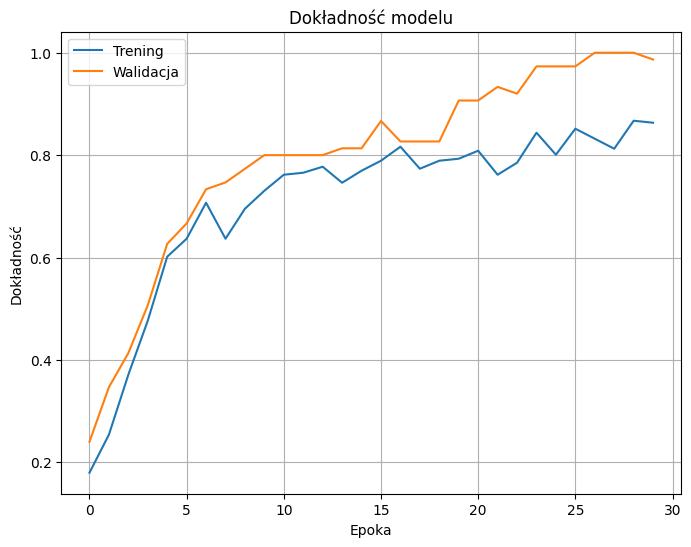

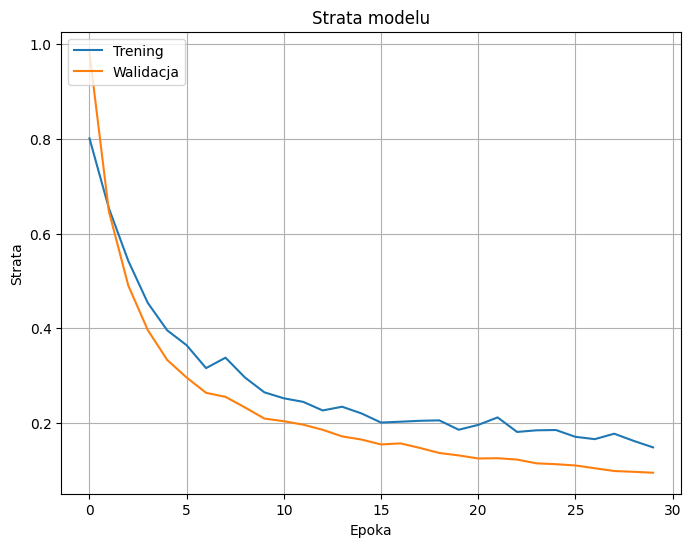

In [ ]:
 %matplotlib inline
# Wykres dokładności
plt.figure(figsize=(8, 6))
plt.plot(model._history.history['categorical_accuracy'])
plt.plot(model._history.history['val_categorical_accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('Dokładność')
plt.xlabel('Epoka')
plt.legend(['Trening', 'Walidacja'], loc='upper left')
plt.grid(True)
plt.show()

# Wykres straty
plt.figure(figsize=(8, 6))
plt.plot(model._history.history['loss'])
plt.plot(model._history.history['val_loss'])
plt.title('Strata modelu')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.legend(['Trening', 'Walidacja'], loc='upper left')
plt.grid(True)
plt.show()


Macierz pomyłek:
[[13  2  3]
 [ 1 21  0]
 [ 2  0 16]]


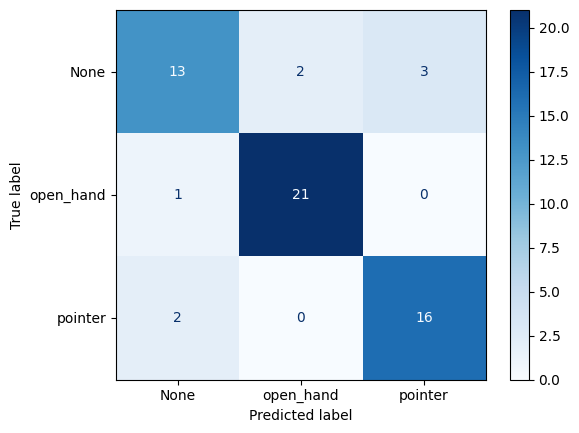

In [ ]:
keras_model = model._model

test_dataset_list = list(test_data.gen_tf_dataset(batch_size=1))

y_true = []
y_pred = []

for idx, sample in enumerate(test_dataset_list):
    y_true_label = np.argmax(sample[1].numpy(), axis=1)[0]
    y_true.append(y_true_label)

    prediction = keras_model.predict(sample[0], verbose=0)
    y_pred_label = np.argmax(prediction, axis=1)[0]
    y_pred.append(y_pred_label)

cm = confusion_matrix(y_true, y_pred)
class_names = train_data.label_names

print('Macierz pomyłek:')
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()